# Empirical Fitting
This looks at methods used to apply fitting of $\Gamma^{\downarrow} = (LW^{\uparrow} - LW^{\downarrow}) + LH^{\uparrow} + SH^{\uparrow}$ in the surface energy busget, so $\Gamma$ can be apporoximated just in terms of surface temperature, $T_s$.

In [1]:
import copy
import sys
import os

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [2]:
# Load dataset - only at surface
def get_annual_zonal_mean(ds):
    ds_av = annual_mean(ds).mean(dim='lon')
    ds_av = ds_av.assign_coords(time=(ds_av.time - ds_av.time.min()).astype(int))
    return ds_av

var_keep = ['temp', 'sphum', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc',
            'flux_lhe', 'flux_t', 'drag_q', 'q_surf', 'p_atm', 'ps', 'q_surf', 'ucomp', 'vcomp', 'w_atm']
# Load dataset

# # DEFAULT experiment
# exp_dir = 'tau_sweep/aquaplanet/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}" for i in range(n_exp)]

# # Experiment with no-WISHE and no convection
# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}_no_conv" for i in range(n_exp)]

# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = ["k=1"]

exp_dir = 'aquaplanet/latent_heat_temp_only/'
exp_name = 'evap=0_1'
# exp_dir = 'aquaplanet/latent_heat_temp_only/depth=20/'
# exp_name = ['base']


# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+exp_name)
p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press']/100
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

n_exp = 1
lat_range = slice(30, 90)               # only consider NH and outside deep tropics, and ignore high latitudes as need 2nd harmonic there
use_time_start = 360*2

ds_use = isca_tools.load_dataset(exp_dir + exp_name)
try:
    ds_use = ds_use[var_keep]
except KeyError:
    remove_keys = []
    for key in var_keep:
        if key not in ds_use:
            print(f'Removing {key} from var_keep')
            remove_keys += [key]
    for key in remove_keys:
        var_keep.remove(key)
    ds_use = ds_use[var_keep]
ds_use = ds_use.sel(time=slice(use_time_start, np.inf)).sel(lat=lat_range)
ds_use = ds_use.sel(pfull=np.inf, method='nearest')      # only keep lowest level
# Compute variables required for flux breakdown
ds_use['emission_factor'] = ds_use.lwdn_sfc/(Stefan_Boltzmann*ds_use.temp**4)
ds_use['temp_diseqb'] = ds_use.t_surf - ds_use.temp
ds_use['rh'] = ds_use.sphum / sphum_sat(ds_use.temp, ds_use.ps*sigma_near_surf)
ds_use['lw_net'] = ds_use.lwup_sfc - ds_use.lwdn_sfc
ds = get_annual_zonal_mean(ds_use).load()
ds_anom = ds - ds.mean(dim='time')       # set everything to be anomaly relative to mean
ds_anom = ds_anom.transpose()            # put latitude as first axis
smooth_ndays = 20
ds_anom = isca_tools.utils.ds_slicing.time_rolling(ds_anom, smooth_ndays)     # smooth array by rolling mean of 20 days
mixed_layer_depth = isca_tools.load_namelist(exp_dir+exp_name)['mixed_layer_nml']['depth']

try:
    evap_prefactor = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['land_evap_prefactor']
except KeyError:
    evap_prefactor = 1

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [4]:
# Make every thing dependent on surface temperature (NOT NEAR-SURFACE) as equation easier to solve
# Link to near-surface with T_{s-a} term in latent flux etc
n_lat = ds.lat.size
time = ds.time.to_numpy()
n_time = time.size
n_resample = n_time

# Define error func to use
error_func_dict = {'max': lambda x, x_approx, norm=False, axis=1: np.max(np.abs(x - x_approx), axis=axis) /
                                                                 (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1),
                   'median': lambda x, x_approx, norm=False, axis=1: np.median(np.abs(x - x_approx), axis=axis) /
                                                                 (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1),
                   'mean': lambda x, x_approx, norm=False, axis=1: np.mean(np.abs(x - x_approx), axis=axis) /
                                                                  (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1)}
error_func_use = 'median'
error_func = error_func_dict[error_func_use.lower()]

def get_lat_ind(lat_approx):
    lat_ind = np.argmin(np.abs(ds.lat.to_numpy()-lat_approx))
    return lat_ind, ds.lat.to_numpy()[lat_ind]

In [5]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax_lims_time = [time[0]-1, time[-1]+1]
ax_lims_lat = [np.floor(ds.lat[0]), np.ceil(ds.lat[-1])]
colors = {'linear': default_colors[0], 'square': default_colors[1], '10': default_colors[3]}
linestyles = {'default': '-', 'resample': ':'}
for key in ['linear', 'square', '10']:
    colors[key+'_phase'] = colors[key]
    linestyles[key] = '-'
    linestyles[key+'_phase'] = '--'

def get_fig_base(lat=None, is_anom=True, n_ax=2):
    fig, ax = plt.subplots(1, n_ax, figsize=(im_sz*n_ax*width['one_col'], im_sz*width['one_col']/ar), sharey=True)
    ax[0].set_xlim(ax_lims_time)
    ax[0].set_xticks(*month_ticks)
    ax[0].set_ylabel('$\chi$')
    ax[1].set_xlabel('$T_s - \overline{T_s}$ [K]')
    if is_anom:
        for ax_use in ax:
            ax_use.axhline(0, color='k', lw=ax_linewidth)
        ax[0].set_ylabel('$\chi - \overline{\chi}$')
    if lat is not None:
        fig.suptitle(f"Lat = ${lat:.0f}\degree$", fontsize=8, y=0.93)
    return fig, ax

def get_fig_error():
    fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar))
    ax.set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|\chi - \chi_{approx}|$')
    ax.set_xlim(ax_lims_lat)
    ax.set_xlabel('Latitude [deg]')
    return fig, ax

## Polynomial Fitting
Some variables in that go into $\Gamma$ are related to temperature through a polynomial e.g.

$\chi \approx \lambda_0 + \lambda T'(t) + \lambda_{sq} T'(t)^2$

We use `np.polyfit` below to fit this.

Later on, in the phase fitting section, we look into resampling. Below we include resampling just to show that it does not make much difference.

In [6]:
var_poly = 'lwup_sfc'
param_poly = {key: {key2: np.zeros((n_lat, 3)) for key2 in ['linear', 'square']} for key in ['default', 'resample']}
var_anom_poly_fit = {key: {key2: np.zeros((n_lat, n_time)) for key2 in ['linear', 'square']} for key in ['default', 'resample']}
for i in tqdm(range(n_lat)):
    for key in var_anom_poly_fit:
        param_poly[key]['linear'][i, 1:] = numerical.polyfit_phase(ds_anom.t_surf[i], ds_anom[var_poly][i], 1, resample='resample' in key,
                                                                   include_phase=False)[1:]
        param_poly[key]['square'][i] = numerical.polyfit_phase(ds_anom.t_surf[i], ds_anom[var_poly][i], 2, resample='resample' in key,
                                                               include_phase=False)[1:]
        for key2 in var_anom_poly_fit['default']:
            var_anom_poly_fit[key][key2][i] = np.polyval(param_poly[key][key2][i], ds_anom.t_surf[i])


  0%|          | 0/21 [00:00<?, ?it/s]

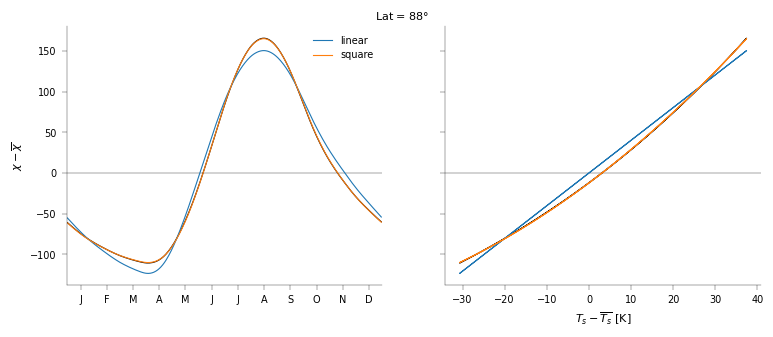

In [7]:
lat_ind_plot, lat_plot = get_lat_ind(90)
show_resample = False
fig, ax = get_fig_base(lat_plot, True)
ax[0].plot(time, ds_anom[var_poly][lat_ind_plot], color='k')
ax[1].plot(ds_anom.t_surf[lat_ind_plot], ds_anom[var_poly][lat_ind_plot], color='k', label='Simulated')
for key in var_anom_poly_fit['default']:
    ax[0].plot(ds.time, var_anom_poly_fit['default'][key][lat_ind_plot], color=colors[key], label=key)
    ax[1].plot(ds_anom.t_surf[lat_ind_plot], var_anom_poly_fit['default'][key][lat_ind_plot], color=colors[key])
    if show_resample:
        ax[0].plot(ds.time, var_anom_poly_fit['resample'][key][lat_ind_plot], color=colors[key], label='resample' if key=='square' else None,
                   linestyle=linestyles['resample'])
        ax[1].plot(ds_anom.t_surf[lat_ind_plot], var_anom_poly_fit['resample'][key][lat_ind_plot], color=colors[key], linestyle=linestyles['resample'])
ax[0].legend()
plt.show()

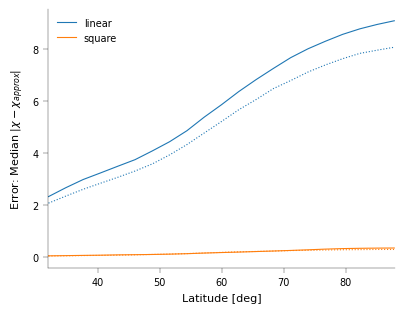

In [8]:
fig, ax = get_fig_error()
for key in var_anom_poly_fit:
    for key2 in var_anom_poly_fit['default']:
        ax.plot(ds.lat, error_func(ds_anom[var_poly].to_numpy(), var_anom_poly_fit[key][key2], norm=False),
                color=colors[key2], linestyle=linestyles[key], label=key2 if key=='default' else None)
ax.legend()
plt.show()

## Phase Fitting
Some variables that go into $\Gamma$ have a clear phase delay, as is apparent in the hysteresis shown below.

Thus, in addition to our polynomial fit above, we would also like a term of the form $\lambda T(t-\Lambda)$ to account for the variable being delayed relative to the temperature by $\Lambda$ days.

However looking at the annual harmonic, $\lambda T(t-\Lambda)$ is equivalent to $\lambda \cos(2\pi f\Lambda)T(t) + \lambda \sin (2\pi f \Lambda)T(t-\frac{1}{4f})$ where $f=1/360 days^{-1}$ is the frequency.

Thus the fitting $\chi(t) \approx \lambda_1 T(t) + \lambda_2 T(t-\Lambda_2)$ is equivalent to $\chi(t) \approx \lambda T(t) +
\lambda_{phase} T(t-\frac{1}{4f})$ and the latter requires less variables.

### $\lambda_{phase}$ Interpretation
We would like to know the phase delay in days, given our $\lambda$ and $\lambda_{phase}$ parameters in the above fit.

Let us re-write $\chi(t) \approx \lambda T(t) + \lambda_{phase} T(t-\frac{1}{4f}) = (\lambda - \lambda_{amp} + \lambda_{amp}) T(t) + \lambda_{phase} T(t-\frac{1}{4f})$ such that the max value of $\lambda_{amp} T(t) + \lambda_{phase} T(t-\frac{1}{4f})$ is $AT_{max}$.

Then we have equations for $A$ and $\Lambda$ such that $AT(t-\Lambda) = \lambda_{amp} T(t) + \lambda_{phase} T(t-\frac{1}{4f})$:

$\lambda_{amp} = A \cos(2\pi f\Lambda)$ and $\lambda_{phase} = A \sin(2\pi f\Lambda)$

### Obtaining $\lambda_{phase}$
Thus, to obtain $\lambda_{phase}$, we first fit a $T_s(t)$ polynomial of a very large degree (10), the residual should be proportional to $T_s(t-\frac{1}{4f})$ which we find via least squares regression.

Rather than $T_s(t-\frac{1}{4f})$, we actually look at $\frac{1}{2}(T_s(t-\frac{1}{4f}) - T_s(t+\frac{1}{4f}))$ which is equal to $T_s(t-\frac{1}{4f})$ if just looking at the first harmonic of $T_s$. But if the second harmonic of $T_s$ is significant, this addition has the effect of cancelling out the second harmonic.

In [72]:
var_phase = 'flux_lhe'
param_phase = {}
for key in ['default', 'resample']:
    param_phase[key] = {}
    param_phase[key]['linear'] = np.zeros((n_lat, 2))
    param_phase[key]['square'] = np.zeros((n_lat, 3))
    param_phase[key]['10'] = np.zeros((n_lat, 11))
var_anom_phase_fit = {key: {key2: np.zeros((n_lat, n_time)) for key2 in ['linear', 'square', '10']} for key in ['default', 'resample']}

for i in tqdm(range(n_lat)):
    for key in param_phase:
        param_phase[key]['linear'][i] = numerical.polyfit_phase(ds_anom.t_surf[i], ds_anom[var_phase][i], 1, include_phase=False,
                                                                resample='resample' in key)[1:]
        param_phase[key]['square'][i] = numerical.polyfit_phase(ds_anom.t_surf[i], ds_anom[var_phase][i], 2,
                                                                include_phase=False, resample='resample' in key)[1:]
        param_phase[key]['10'][i] = numerical.polyfit_phase(ds_anom.t_surf[i], ds_anom[var_phase][i], 10,
                                                            include_phase=False, resample='resample' in key)[1:]
        for key2 in var_anom_phase_fit['default']:
            var_anom_phase_fit[key][key2][i] = np.polyval(param_phase[key][key2][i], ds_anom.t_surf[i])

  0%|          | 0/21 [00:00<?, ?it/s]

In [73]:
# Get fit including phase
with tqdm(total=n_lat*2) as pbar:
    for key in ['default', 'resample']:
        param_phase[key]['linear_phase'] = np.zeros((n_lat, 3))
        param_phase[key]['square_phase'] = np.zeros((n_lat, 4))
        param_phase[key]['10_phase'] = np.zeros((n_lat, 12))
        for key2 in ['linear_phase', 'square_phase', '10_phase']:
            var_anom_phase_fit[key][key2] = np.zeros((n_lat, n_time))
        for i in range(n_lat):
            param_phase[key]['linear_phase'][i] = numerical.polyfit_phase(ds_anom.t_surf[i], ds_anom[var_phase][i], 1, resample='resample' in key)
            param_phase[key]['square_phase'][i] = numerical.polyfit_phase(ds_anom.t_surf[i], ds_anom[var_phase][i], 2, resample='resample' in key)
            param_phase[key]['10_phase'][i] = numerical.polyfit_phase(ds_anom.t_surf[i], ds_anom[var_phase][i], 10, resample='resample' in key)
            for key2 in ['linear_phase', 'square_phase', '10_phase']:
                var_anom_phase_fit[key][key2][i] = numerical.polyval_phase(param_phase[key][key2][i], ds_anom.t_surf[i].to_numpy())
            pbar.update(1)

  0%|          | 0/42 [00:00<?, ?it/s]

#### $\lambda_{phase}$: Step 1 - high polynomial fit

We first fit a 10 polynomial fit to the variable $\chi$ as shown below to give $\chi_{10poly}$. This is fit seems to be better for the resampled data to the eye.

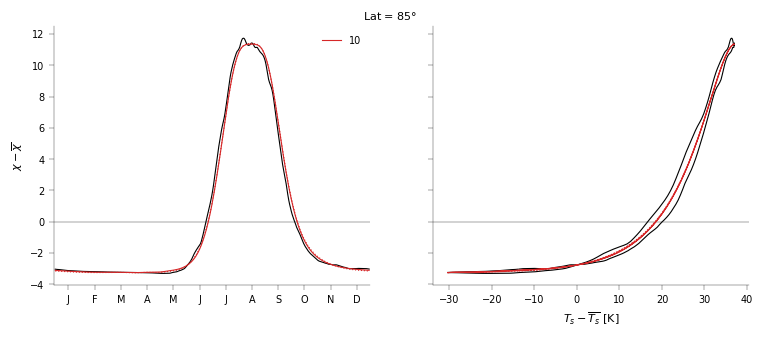

In [74]:
lat_ind_plot, lat_plot = get_lat_ind(85)
fig, ax = get_fig_base(lat_plot, True)
ax[0].plot(time, ds_anom[var_phase][lat_ind_plot], color='k')
ax[1].plot(ds_anom.t_surf[lat_ind_plot], ds_anom[var_phase][lat_ind_plot], color='k', label='Simulated')
show_resample=True
for key in ['10']:
    ax[0].plot(ds.time, var_anom_phase_fit['default'][key][lat_ind_plot], color=colors[key], label=key)
    ax[1].plot(ds_anom.t_surf[lat_ind_plot], var_anom_phase_fit['default'][key][lat_ind_plot], color=colors[key])
    if show_resample:
        ax[0].plot(ds.time, var_anom_phase_fit['resample'][key][lat_ind_plot], color=colors[key], label='resample' if key=='square' else None,
                   linestyle=linestyles['resample'])
        ax[1].plot(ds_anom.t_surf[lat_ind_plot], var_anom_phase_fit['resample'][key][lat_ind_plot], color=colors[key], linestyle=linestyles['resample'])
ax[0].legend()
plt.show()

In [75]:
# plt.scatter(ds_anom.t_surf[lat_ind_plot], ds_anom[var_phase][lat_ind_plot], color='k')
# x = isca_tools.utils.ds_slicing.time_rolling(ds_anom.t_surf[lat_ind_plot], 20)
# y = isca_tools.utils.ds_slicing.time_rolling(ds_anom[var_phase][lat_ind_plot], 20)
# # plt.scatter(x, y, color='k')
# param_use = np.polyfit(ds_anom.t_surf[lat_ind_plot], ds_anom[var_phase][lat_ind_plot], 10)
# plt.plot(ds_anom.t_surf[lat_ind_plot], np.polyval(param_use, ds_anom.t_surf[lat_ind_plot]), color='k')
#
# # param_use = np.polyfit(x, y, 10)
# # plt.plot(ds_anom.t_surf[lat_ind_plot], np.polyval(param_use, ds_anom.t_surf[lat_ind_plot]), color='r')
#
# x_resample, y_resample = numerical.resample_data(None, ds_anom.t_surf[lat_ind_plot], ds_anom[var_phase][lat_ind_plot])[1:]
# param_use = np.polyfit(x_resample, y_resample, 10)
# plt.plot(x_resample, np.polyval(param_use, x_resample), color=default_colors[0])
#
# x_resample, y_resample = numerical.resample_data_distance(None, ds_anom.t_surf[lat_ind_plot], ds_anom[var_phase][lat_ind_plot], norm=False)[1:]
# # plt.scatter(x_resample, y_resample, color='k')
# param_use = np.polyfit(x_resample, y_resample, 10)
# plt.plot(x_resample, np.polyval(param_use, x_resample), color=default_colors[1])
#
# # x_resample, y_resample = numerical.resample_data_distance(None, x, y, norm=True)[1:]
# # param_use = np.polyfit(x_resample, y_resample, 10)
# # plt.plot(x_resample, np.polyval(param_use, x_resample), color=default_colors[2])
# plt.show()

#### $\lambda_{phase}$: Step 2 - fitting

To the residual we find the parameters $\lambda_0$ and $\lambda_{phase}$ such that  $\chi-\chi_{10poly} \approx \lambda_{phase} T_{shift1} =  \lambda_{phase}\frac{1}{2}(T'(t-\mathcal{T}/4) - T'(t+\mathcal{T}/4))$. This fit is shown by the red line below.

As it has to fit a single phase to the entire cycle, it over-estimates the phase in some places and underestimates it elsewhere.

[-5.58427609e-03 -1.52985255e-07]
-0.005584276085541529
[-0.00949607 -0.04145278]
-0.009496069119503212


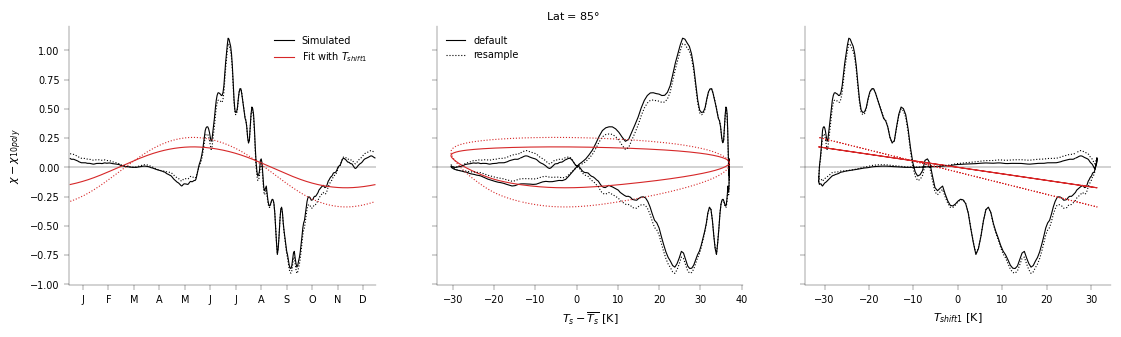

In [76]:
temp_shift = 0.5 * (numerical.get_var_shift(ds_anom.t_surf[lat_ind_plot], shift_phase=0.25) -
                 numerical.get_var_shift(ds_anom.t_surf[lat_ind_plot], shift_phase=-0.25))
key_poly_plot = '10'
fig_phase_fit, ax = get_fig_base(lat_plot, True, 3)
for key in var_anom_phase_fit:
    ax[0].plot(time, ds_anom[var_phase][lat_ind_plot]-var_anom_phase_fit[key][key_poly_plot][lat_ind_plot],
               color='k', linestyle=linestyles[key], label='Simulated' if key=='default' else None)
    ax[1].plot(ds_anom.t_surf[lat_ind_plot], ds_anom[var_phase][lat_ind_plot]-
               var_anom_phase_fit[key][key_poly_plot][lat_ind_plot], color='k', linestyle=linestyles[key], label=key)
    ax[2].plot(temp_shift,
               ds_anom[var_phase][lat_ind_plot]-var_anom_phase_fit[key][key_poly_plot][lat_ind_plot], color='k',
               linestyle=linestyles[key])

    resid_param = numerical.polyfit_phase(ds_anom.t_surf[lat_ind_plot], ds_anom[var_phase][lat_ind_plot], deg=-1, resample='resample' in key)
    print(resid_param)
    print(param_phase[key]['10_phase'][lat_ind_plot, 0])
    resid_approx = numerical.polyval_phase(resid_param, ds_anom.t_surf[lat_ind_plot])

    ax[0].plot(time, resid_approx, color=colors['10_phase'],
               linestyle=linestyles[key], label='Fit with $T_{shift1}$' if key=='default' else None)
    ax[1].plot(ds_anom.t_surf[lat_ind_plot], resid_approx, color=colors['10_phase'],
               linestyle=linestyles[key])
    ax[2].plot(temp_shift, resid_approx, color=colors['10_phase'],
               linestyle=linestyles[key])
    # print(param)
    # ax[1].plot(ds_anom.t_surf[lat_ind_plot], param2, color=default_colors[1], linestyle=linestyles[key])
    # ax[2].plot(temp_shift, param2, color=default_colors[1], linestyle=linestyles[key])
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel(f"$\chi - \chi_{'{'+key_poly_plot+' poly}'}$")
ax[2].set_xlabel("$T_{shift1}$ [K]")
plt.show()

#### $\lambda_{phase}$: Step 3 - final fit, polynomial with phase

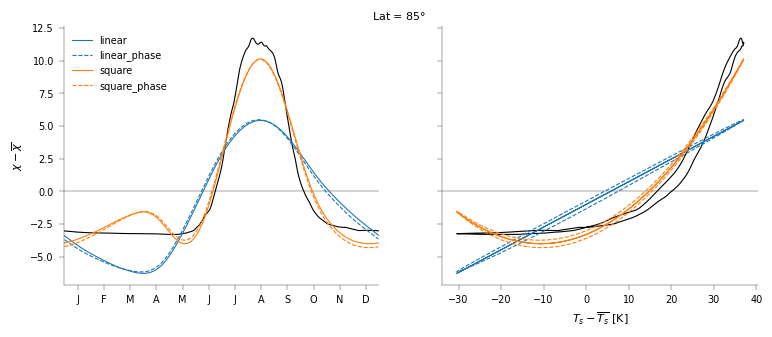

In [77]:
fig, ax = get_fig_base(lat_plot, True)
ax[0].plot(time, ds_anom[var_phase][lat_ind_plot], color='k')
ax[1].plot(ds_anom.t_surf[lat_ind_plot], ds_anom[var_phase][lat_ind_plot], color='k', label='Simulated')
key_plot = 'resample'
for key in ['linear', 'linear_phase', 'square', 'square_phase']:
    ax[0].plot(ds.time, var_anom_phase_fit[key_plot][key][lat_ind_plot], color=colors[key], label=key, linestyle=linestyles[key])
    ax[1].plot(ds_anom.t_surf[lat_ind_plot], var_anom_phase_fit[key_plot][key][lat_ind_plot], color=colors[key], linestyle=linestyles[key])
ax[0].legend()
plt.show()

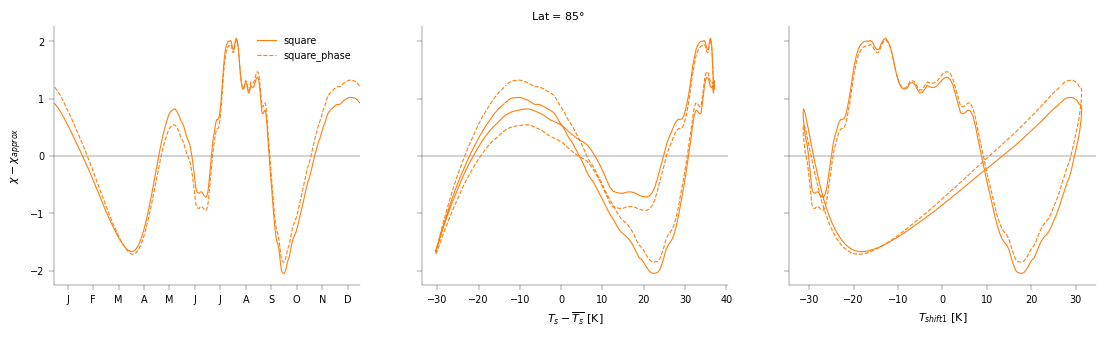

In [78]:
fig, ax = get_fig_base(lat_plot, True, 3)
key_plot = 'resample'
for key in ['square', 'square_phase']:
    ax[0].plot(time, ds_anom[var_phase][lat_ind_plot]-var_anom_phase_fit[key_plot][key][lat_ind_plot],
               color=colors[key], linestyle=linestyles[key], label=key)
    ax[1].plot(ds_anom.t_surf[lat_ind_plot], ds_anom[var_phase][lat_ind_plot]-
               var_anom_phase_fit[key_plot][key][lat_ind_plot], color=colors[key], linestyle=linestyles[key])
    ax[2].plot(temp_shift,
               ds_anom[var_phase][lat_ind_plot]-var_anom_phase_fit[key_plot][key][lat_ind_plot], color=colors[key], linestyle=linestyles[key])
ax[0].legend()
ax[0].set_ylabel("$\chi - \chi_{approx}$")
ax[2].set_xlabel("$T_{shift1}$ [K]")
plt.show()

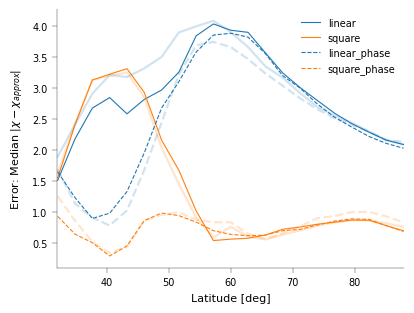

In [79]:
fig, ax = get_fig_error()
show_resample=True
for key in ['default', 'resample']:
    for key2 in var_anom_phase_fit['default']:
        if '10' in key2 or 'fourier' in key2:
            continue
        ax.plot(ds.lat, error_func(ds_anom[var_phase].to_numpy(), var_anom_phase_fit[key][key2], norm=False),
                color=colors[key2], linestyle=linestyles[key2], label=key2 if key=='default' else None, alpha=0.2 if key=='resample' else 1,
                lw=plt.rcParams['lines.linewidth']*2 if key=='resample' else plt.rcParams['lines.linewidth'])
ax.legend()
plt.show()

## 2nd Shift Term
The error after the phase shifting has a characteristic figure of 8 cycle, indicating that we need something with a period of half a year, rather than a year to try and fit this.

The 2nd harmonic, has this period, and can be isolated through another shift term: $T_{shift2} = -\frac{1}{2}(T'(t-\mathcal{T}/4) + T'(t+\mathcal{T}/4))$

This is shown below, the difference is due to higher order harmonics.

It sort of looks like the residual above, so maybe can be used to explain it.

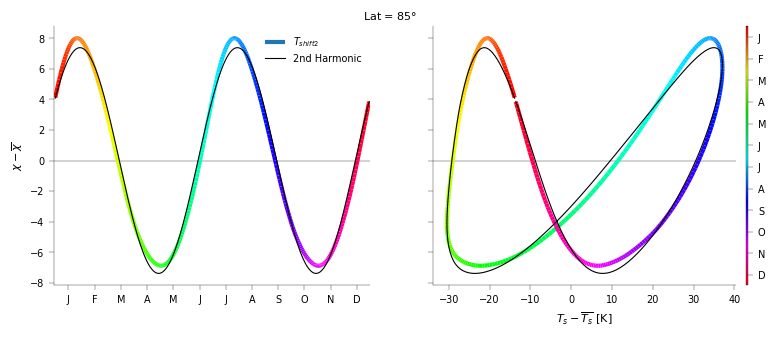

In [80]:
fourier_info = fourier.get_fourier_fit(time, ds_anom.t_surf[lat_ind_plot], 2)
t_surf_2_harmonic = fourier.fourier_series(time, [0, 0, fourier_info[1][-1]], [0, fourier_info[2][-1]])
temp_shift2 = -0.5 * (numerical.get_var_shift(ds_anom.t_surf[lat_ind_plot], shift_phase=0.25) +
                 numerical.get_var_shift(ds_anom.t_surf[lat_ind_plot], shift_phase=-0.25))

fig, ax = get_fig_base(lat_plot, True)
colored_line(time, temp_shift2, c=time, cmap='hsv', label='$T_{shift2}$', ax=ax[0], lw=3)
ax[0].plot(time, t_surf_2_harmonic, color='k', label='2nd Harmonic')
im = colored_line(ds_anom.t_surf[lat_ind_plot], temp_shift2, c=time, cmap='hsv', label='$T_{shift2}$', ax=ax[1], lw=3)
ax[1].plot(ds_anom.t_surf[lat_ind_plot], t_surf_2_harmonic, color='k', label='2nd Harmonic')
cbar = fig.colorbar(im, ax=ax[1], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
ax[0].legend()
plt.show()

### Fitting with $T_{shift2}$
Below we see that it does not give much improvement though, so perhaps it is best to not use this.

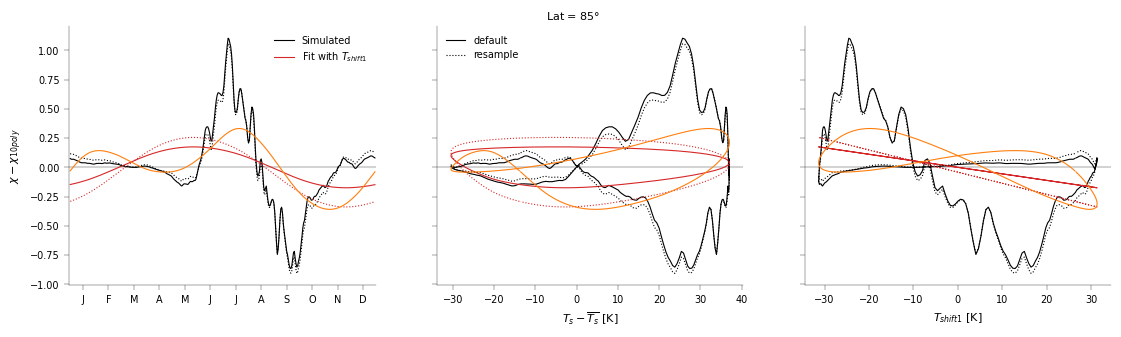

In [81]:
def fit_func_with_tempshift2(temp, a, b, c):
    temp_shift = 0.5 * (numerical.get_var_shift(temp, shift_phase=0.25) -
                 numerical.get_var_shift(temp, shift_phase=-0.25))
    temp_shift2 = -0.5 * (numerical.get_var_shift(temp, shift_phase=0.25) +
                 numerical.get_var_shift(temp, shift_phase=-0.25))
    return a + b*temp_shift + c*temp_shift2

fig = copy.deepcopy(fig_phase_fit)
ax = np.asarray(fig.get_axes())

key_poly_plot = '10'
for key in var_anom_phase_fit:
    if key == 'resample':
        # Too complicated to do calculation with tempshift2 as well.
        continue
    else:
        resid_param = scipy.optimize.curve_fit(fit_func_with_tempshift2, ds_anom.t_surf[lat_ind_plot].to_numpy(),
                                               (ds_anom[var_phase][lat_ind_plot]-
               var_anom_phase_fit[key][key_poly_plot][lat_ind_plot]).to_numpy())[0]
    resid_approx = fit_func_with_tempshift2(ds_anom.t_surf[lat_ind_plot], *resid_param)
    ax[0].plot(time, resid_approx, color=default_colors[1],
               linestyle=linestyles[key],  label='Fit with $T_{shift1}$ and $T_{shift2}$' if key=='default' else None)
    ax[1].plot(ds_anom.t_surf[lat_ind_plot], resid_approx, color=default_colors[1],
               linestyle=linestyles[key])
    ax[2].plot(temp_shift, resid_approx, color=default_colors[1],
               linestyle=linestyles[key])
ax[1].legend()
fig

## Fourier Residual
Below we fit a fourier series (just 2nd harmonic) to residual after 10 polynomial and phase fitting has been done. This allows a seasonal variation to be added to the variable. So now full fit including squared term, phase term, and residual is:

$\chi(t) \approx \lambda_0 + \lambda T(t) + \lambda_{sq} T^2(t) + \lambda_{phase} T_{shift}(t) + \Lambda \cos(4\pi ft) + \Lambda_{phase} \cos(4\pi ft - \frac{1}{8f})$

where $\Lambda$ and $\Lambda_{phase}$ can be obtained from the $\lambda$ and $\phi$ in the normal fourier expansion: $\lambda \cos(4\pi ft - \phi)$. But in this form, it allows addition of different variables.

It is important to note that we are saying that this residual is independent of temperature, so can be interpreted as a modification to the shortwave radiation in the surface energy budget.

In [98]:
for key in var_anom_phase_fit:
    var_anom_phase_fit[key]['residual_fourier'] = np.zeros((n_lat, n_time))
    # var_anom_phase_fit[key]['residual_fourier2'] = np.zeros((n_lat, n_time))
    param_phase[key]['residual_fourier'] = np.zeros((n_lat, 2))       # record fourier coefficients
    for i in range(n_lat):
        # fourier_info = fourier.get_fourier_fit(time, ds_anom[var_phase][i]-var_anom_phase_fit[key]['10_phase'][i], time.size, 2)
        fourier_info = fourier.get_fourier_fit(time, ds_anom[var_phase][i]-var_anom_phase_fit[key]['10_phase'][i], 1)
        param_phase[key]['residual_fourier'][i, 0] =  fourier_info[1][-1]
        param_phase[key]['residual_fourier'][i, 1] =  fourier_info[2][-1]
        # print(resid_param)
        # print(fourier_info[1][0], fourier_info[1][2], fourier_info[2][1])
        var_anom_phase_fit[key]['residual_fourier'][i] = fourier_info[0]
        # var_anom_phase_fit[key]['residual_fourier'][i] = resid_approx
        # var_anom_phase_fit[key]['residual_fourier'][i] = fourier.fourier_series(time, time.size, [fourier_info[1][0], 0, fourier_info[1][-1]],
        #                                                                          [0, fourier_info[2][-1]])

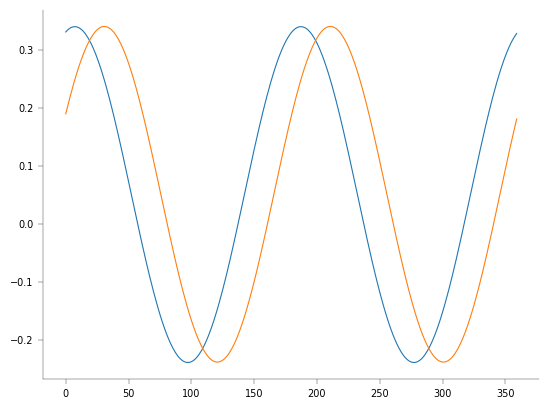

In [95]:
fourier_info = fourier.get_fourier_fit(time, ds_anom[var_phase][i]-var_anom_phase_fit[key]['10_phase'][i], 2)
plt.plot(fourier.fourier_series(time, [fourier_info[1][0], 0, fourier_info[1][-1]],
                                                                                 [0, fourier_info[2][-1]]))
fourier_info = fourier.get_fourier_fit(time, ds_anom[var_phase][i]-var_anom_phase_fit[key]['10_phase'][i], 1)
plt.plot(fourier_info[0])


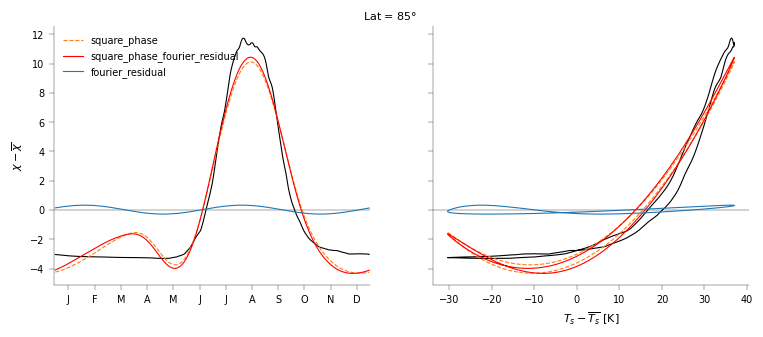

In [99]:
fig, ax = get_fig_base(lat_plot, True)
ax[0].plot(time, ds_anom[var_phase][lat_ind_plot], color='k')
ax[1].plot(ds_anom.t_surf[lat_ind_plot], ds_anom[var_phase][lat_ind_plot], color='k', label='Simulated')
key_plot = 'resample'
for key in ['square_phase']:
    ax[0].plot(ds.time, var_anom_phase_fit[key_plot][key][lat_ind_plot], color=colors[key], label=key, linestyle=linestyles[key])
    ax[0].plot(ds.time, var_anom_phase_fit[key_plot][key][lat_ind_plot] + var_anom_phase_fit[key_plot]['residual_fourier'][lat_ind_plot],
               color='r', label=key+'_fourier_residual')
    # ax[0].plot(ds.time, var_anom_phase_fit[key_plot][key][lat_ind_plot] + var_anom_phase_fit[key_plot]['residual_fourier2'][lat_ind_plot],
    #            color='r', label=key+'_fourier_residual2', linestyle=':')
    ax[1].plot(ds_anom.t_surf[lat_ind_plot], var_anom_phase_fit[key_plot][key][lat_ind_plot], color=colors[key], linestyle=linestyles[key])
    ax[1].plot(ds_anom.t_surf[lat_ind_plot], var_anom_phase_fit[key_plot][key][lat_ind_plot] +
               var_anom_phase_fit[key_plot]['residual_fourier'][lat_ind_plot], color='r')
    # ax[1].plot(ds_anom.t_surf[lat_ind_plot], var_anom_phase_fit[key_plot][key][lat_ind_plot] +
    #            var_anom_phase_fit[key_plot]['residual_fourier2'][lat_ind_plot], color='r', linestyle=':')
    ax[0].plot(time, var_anom_phase_fit[key_plot]['residual_fourier'][lat_ind_plot], label='fourier_residual')
    ax[1].plot(ds_anom.t_surf[lat_ind_plot], var_anom_phase_fit[key_plot]['residual_fourier'][lat_ind_plot], label='fourier_residual')
ax[0].legend()
plt.show()

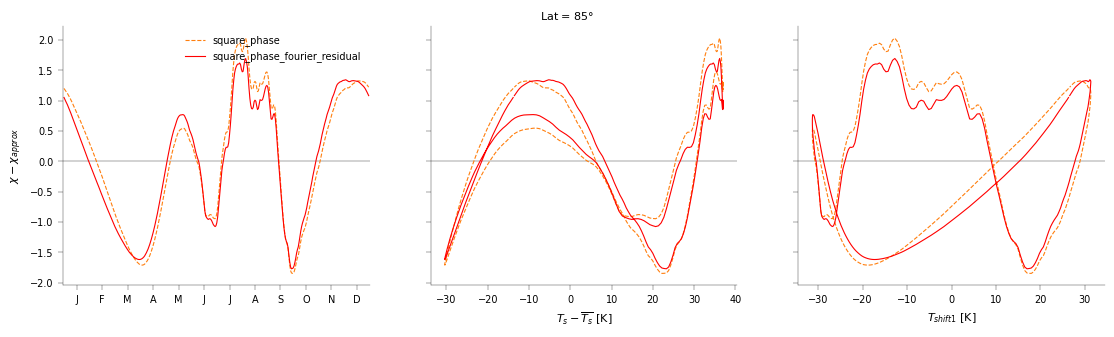

In [100]:
fig, ax = get_fig_base(lat_plot, True, 3)
key_plot = 'resample'
for key in ['square_phase']:
    var_approx = var_anom_phase_fit[key_plot][key][lat_ind_plot]
    ax[0].plot(time, ds_anom[var_phase][lat_ind_plot]-var_approx,
               color=colors[key], linestyle=linestyles[key], label=key)
    ax[1].plot(ds_anom.t_surf[lat_ind_plot], ds_anom[var_phase][lat_ind_plot]-var_approx, color=colors[key], linestyle=linestyles[key])
    ax[2].plot(temp_shift, ds_anom[var_phase][lat_ind_plot]-var_approx, color=colors[key], linestyle=linestyles[key])
    var_approx = var_anom_phase_fit[key_plot][key][lat_ind_plot] + var_anom_phase_fit[key_plot]['residual_fourier'][lat_ind_plot]
    ax[0].plot(time, ds_anom[var_phase][lat_ind_plot]-var_approx, color='r', linestyle='-', label=key+'_fourier_residual')
    ax[1].plot(ds_anom.t_surf[lat_ind_plot], ds_anom[var_phase][lat_ind_plot]-var_approx, color='r', linestyle='-')
    ax[2].plot(temp_shift, ds_anom[var_phase][lat_ind_plot]-var_approx, color='r', linestyle='-')
    # var_approx = var_anom_phase_fit[key_plot][key][lat_ind_plot] + var_anom_phase_fit[key_plot]['residual_fourier2'][lat_ind_plot]
    # ax[0].plot(time, ds_anom[var_phase][lat_ind_plot]-var_approx, color='r', linestyle=':', label=key+'_fourier_residual2')
    # ax[1].plot(ds_anom.t_surf[lat_ind_plot], ds_anom[var_phase][lat_ind_plot]-var_approx, color='r', linestyle=':')
    # ax[2].plot(temp_shift, ds_anom[var_phase][lat_ind_plot]-var_approx, color='r', linestyle=':')
ax[0].legend()
ax[0].set_ylabel("$\chi - \chi_{approx}$")
ax[2].set_xlabel("$T_{shift1}$ [K]")
plt.show()

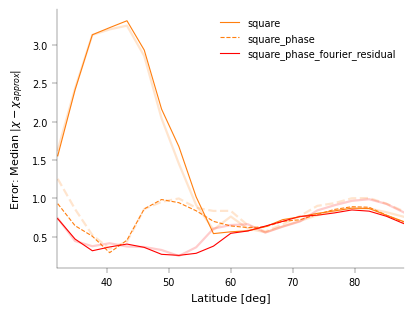

In [101]:
fig, ax = get_fig_error()
for key in ['default', 'resample']:
    for key2 in ['square', 'square_phase']:
        ax.plot(ds.lat, error_func(ds_anom[var_phase].to_numpy(), var_anom_phase_fit[key][key2], norm=False),
                color=colors[key2], linestyle=linestyles[key2], label=key2 if key=='default' else None, alpha=0.2 if key=='resample' else 1,
                lw=plt.rcParams['lines.linewidth']*2 if key=='resample' else plt.rcParams['lines.linewidth'])
        if key2 == 'square_phase':
            ax.plot(ds.lat, error_func(ds_anom[var_phase].to_numpy(), var_anom_phase_fit[key][key2]+var_anom_phase_fit[key]['residual_fourier'],
                                       norm=False),
                color='r', linestyle='-', label=key2+'_fourier_residual' if key=='default' else None, alpha=0.2 if key=='resample' else 1,
                lw=plt.rcParams['lines.linewidth']*2 if key=='resample' else plt.rcParams['lines.linewidth'])
            # ax.plot(ds.lat, error_func(ds_anom[var_phase].to_numpy(), var_anom_phase_fit[key][key2]+var_anom_phase_fit[key]['residual_fourier2'],
            #                            norm=False),
            #     color='r', linestyle=':', label=key2+'_fourier_residual2' if key=='default' else None, alpha=0.2 if key=='resample' else 1,
            #     lw=plt.rcParams['lines.linewidth']*2 if key=='resample' else plt.rcParams['lines.linewidth'])
ax.legend()
plt.show()

### Variation of Parameters
Below I plot how the 6 parameters in the approximation: $\chi(t) \approx \lambda_0 + \lambda T(t) + \lambda_{sq} T^2(t) + \lambda_{phase} T_{shift}(t) + \Lambda \cos(4\pi ft) + \Lambda_{phase} \cos(4\pi ft - \frac{1}{8f})$
vary with latitude.

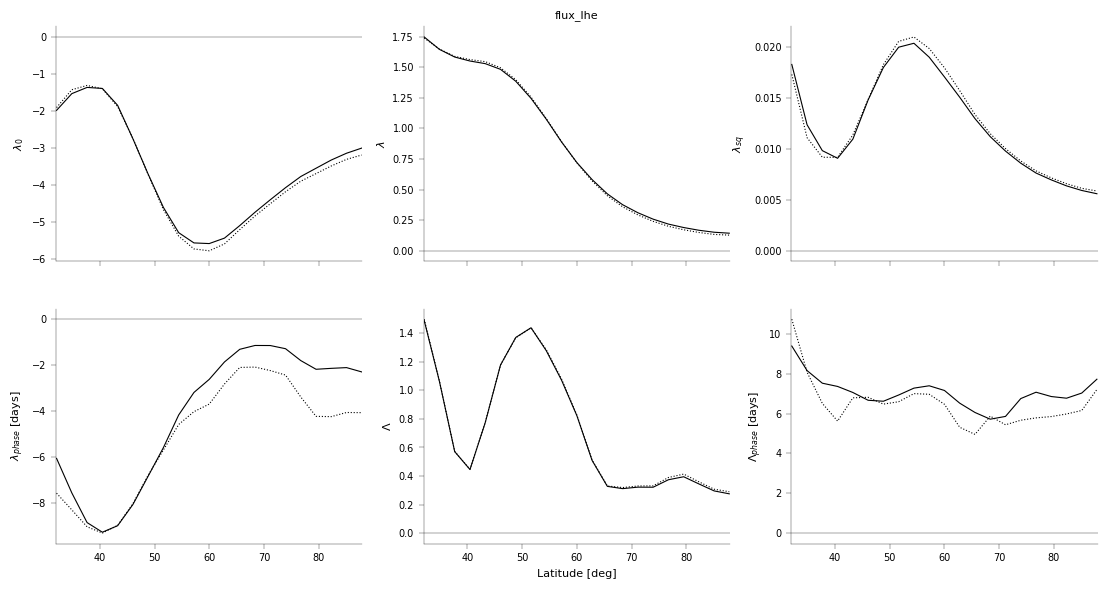

In [88]:
key_plot = 'square_phase'
fig, ax = plt.subplots(2, 3, figsize=(im_sz*3*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True)
for key in param_phase:
    ax[0, 0].plot(ds_anom.lat, param_phase[key][key_plot][:, -1], color='k', linestyle=linestyles[key])
    if 'phase' in key_plot:
        # Convert phase to days as easier to interpret if there is phase fitting done
        amp_coef, phase_coef = fourier.coef_conversion(cos_coef=param_phase[key][key_plot][:, -2],
                                                       sin_coef=param_phase[key][key_plot][:, 0])
        ax[0, 1].plot(ds_anom.lat, amp_coef, color='k', linestyle=linestyles[key])
        ax[1, 0].plot(ds_anom.lat, phase_coef/(2*np.pi)*360, color='k', linestyle=linestyles[key])
    else:
        ax[0, 1].plot(ds_anom.lat, param_phase[key][key_plot][:, -2], color='k', linestyle=linestyles[key])
    if 'square' in key_plot:
        ax[0, 2].plot(ds_anom.lat, param_phase[key][key_plot][:, -3], color='k', linestyle=linestyles[key])
    ax[1, 1].plot(ds_anom.lat, param_phase[key]['residual_fourier'][:, 0], color='k', linestyle=linestyles[key])
    ax[1, 2].plot(ds_anom.lat, param_phase[key]['residual_fourier'][:, 1]/(4*np.pi)*360, color='k', linestyle=linestyles[key])
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
ax[0,0].set_xlim(ax_lims_lat)
ax[0, 0].set_ylabel('$\lambda_0$')
ax[0, 1].set_ylabel('$\lambda$')
ax[0, 2].set_ylabel('$\lambda_{sq}$')
ax[1, 0].set_ylabel('$\lambda_{phase}$ [days]')
ax[1, 1].set_ylabel('$\Lambda$')
ax[1, 2].set_ylabel('$\Lambda_{phase}$ [days]')
ax[1, 1].set_xlabel('Latitude [deg]')
ax[0, 1].set_title(var_phase)

plt.show()